In [1]:
import matplotlib
import json
import numpy as np
import pandas as pd
import datetime
import time
import math
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
from scipy.special import boxcox1p, inv_boxcox
from scipy.stats import boxcox_normmax

import matplotlib
from matplotlib.font_manager import FontProperties

matplotlib.rcParams['font.sans-serif']='Times New Roman'
matplotlib.rcParams['font.size'] =16 
matplotlib.rcParams['mathtext.fontset'] ='stix'
matplotlib.rcParams['axes.unicode_minus'] = False 


def evaluation_indicators(true_data,predict_data):
    true_data=np.array(true_data).reshape(-1,)
    predict_data=np.array(predict_data).reshape(-1,)
    
    mean_true_data=sum(true_data)/len(true_data)
    error=np.array(true_data)-np.array(predict_data)
    squareerror=error*error
    abserror=abs(error)
    relativeerror=abserror/true_data
    MSE=sum(squareerror)/len(squareerror)
    RMSE=MSE**(1/2)
    MAE=sum(abserror)/len(abserror)
    ARE=sum(relativeerror)/len(relativeerror)
    NSE=1-sum(squareerror)/sum((true_data-mean_true_data)**2)
    

    times=sum(relativeerror<0.2)
    
    true_data=np.array(true_data)
    predict_data=np.array(predict_data)
    Ex=true_data.mean()
    Ey=predict_data.mean()
    Exy=(true_data*predict_data).mean()
    Dx=(true_data*true_data).mean()-Ex*Ex
    Dy=(predict_data*predict_data).mean()-Ey*Ey
    r=(Exy-Ex*Ey)/((Dx*Dy)**(1/2))
    
    R2=1-MSE/(sum((true_data-mean_true_data)**2)/len(true_data))
    
    return [round(MSE,4),round(RMSE,4),round(MAE,4),round(ARE,4),\
            round(NSE,4),round(times/len(true_data),4),round(r,4),round(R2,4)]


import hydro_utils
from xarray.core.dataarray import DataArray

def evaluation_indicators(true_data, predict_data):
    true_data = DataArray(true_data)
    predict_data = DataArray(predict_data)
    
    metrics_name = hydro_utils.metrics.get_available_metrics()
    temp = hydro_utils.metrics.calculate_all_metrics(true_data,predict_data)
    result = [temp[i] for i in metrics_name]
    
    return result


from sklearn.metrics import precision_score, recall_score, f1_score
def evaluation_indicators_classification(true_lable, prediction):
    true_lable = np.array(true_lable).reshape(-1,)
    prediction = np.array(prediction).reshape(-1,)
    
    result = []
    #----------------------------- precision-----------------------------
    result.extend(precision_score(true_lable, prediction, average=None))
    result.append(precision_score(true_lable, prediction, average='micro'))
    result.append(precision_score(true_lable, prediction, average='macro'))
    result.append(precision_score(true_lable, prediction, average='weighted'))

    #----------------------------- recall-----------------------------
    result.extend(recall_score(true_lable, prediction, average=None))
    result.append(recall_score(true_lable, prediction, average='micro'))
    result.append(recall_score(true_lable, prediction, average='macro'))
    result.append(recall_score(true_lable, prediction, average='weighted'))

    #----------------------------- F1-value-----------------------------
    result.extend(f1_score(true_lable, prediction, average=None))
    result.append(f1_score(true_lable, prediction, average='micro'))
    result.append(f1_score(true_lable, prediction, average='macro'))
    result.append(f1_score(true_lable, prediction, average='weighted'))
    
    return result

In [2]:
trainStartDate = '1982-01-01'
trainEndDate = '2013-12-31'
testStartDate = '2014-01-1'
testEndDate = '2018-12-31'
trainDayLength = int((pd.to_datetime(trainEndDate)-pd.to_datetime(trainStartDate))/pd.Timedelta(1, 'day'))+1

##############################################################
with open(r'F:\jupyter_notebook\usa\result\stationID.txt', 'r') as f:
    all_stationID = f.readlines()

In [122]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_indicators_a = []
lstm_naive_indicators_a = []
for ID_i in range(0,len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood_20 = allData.iloc[-dayLength:,0].quantile(0.2)
    low_flood_40 = allData.iloc[-dayLength:,0].quantile(0.4)
    low_flood_60 = allData.iloc[-dayLength:,0].quantile(0.6)
    low_flood_80 = allData.iloc[-dayLength:,0].quantile(0.8)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    ytest_naive_ = ytest[:-1].copy()
    ytest = ytest[1:]
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f))[1:]

    lstm_indicators_a.append([])
    lstm_indicators_a[-1].append(evaluation_indicators(ytest, ytest_))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_[ytest<low_flood_20]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_[ytest>low_flood_80]))
    
    lstm_naive_indicators_a.append([])
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest, ytest_naive_))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_naive_[ytest<low_flood_20]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_naive_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_naive_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_naive_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_naive_[ytest>low_flood_80]))

lstm_indicators_a = np.array(lstm_indicators_a)
lstm_naive_indicators_a = np.array(lstm_naive_indicators_a)

273


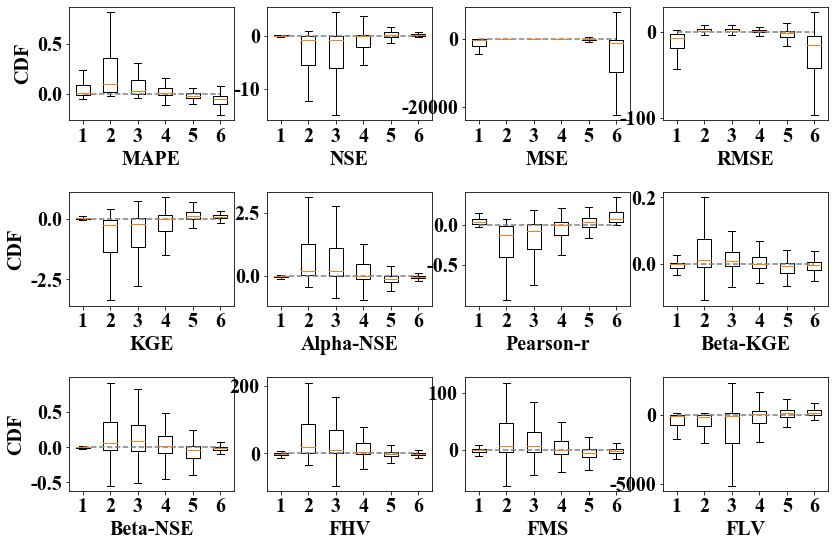

In [31]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    axs[(i)//4,(i)%4].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,i],showfliers=False)
    axs[(i)//4,(i)%4].plot([1,6],[0,0],ls='--',c='grey')

    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

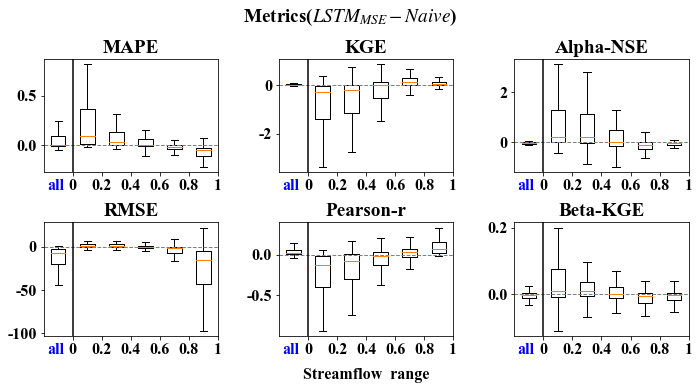

In [123]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((lstm_indicators_a - lstm_naive_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
axs[1,1].set_xlabel('Streamflow  range',labelpad=10)
plt.suptitle(t='Metrics($LSTM_{MSE} - Naive$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_MSE_Naive.jpg',dpi=300)
plt.show()

273


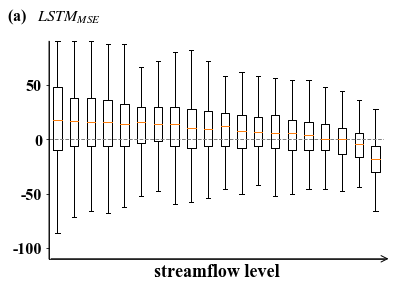

In [315]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_AE = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    ytest = allData[-dayLength:].iloc[10:,0].values
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = json.load(f)
    
    lstm_AE.append((ytest_-ytest)[[np.argsort(ytest)]])

lstm_AE = np.array(lstm_AE)

# ============================================
temp = (lstm_AE>0)*2-1
cut = np.arange(0,temp.shape[1],temp.shape[1]//20)
cut[-1] = temp.shape[1]
a=[]
for i in range(len(cut)-1):
    a.append(temp[:,cut[i]:cut[i+1]].sum(1))
    
plt.boxplot(a,showfliers=False)
plt.plot([0.5,20.5],[0,0],lw=1,ls='--',c='grey')
plt.xticks([])
plt.annotate('', 
             xy=(1.02, 0), xycoords='axes fraction',
             xytext=(0, 0), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             zorder=50
            )
plt.annotate('', 
             xy=(0, 1.01), xycoords='axes fraction',
             xytext=(0, -0.01), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-'),
             zorder=50
            )
[plt.gca().spines[loc_axis].set_visible(False) for loc_axis in ['top','right']]
plt.xlabel('streamflow level',fontsize=18)
plt.ylim(-110,90)
plt.text(-2,110,'(a)   $LSTM_{MSE}$')
plt.savefig(r'F:\objcetive_based_ensemble\figures\balance_a.jpg',dpi=300)
plt.show()

In [64]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_indicators_a = []
lstm_naive_indicators_a = []
lstm_mapel_indicators_a = []
for ID_i in range(0,len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood_20 = allData.iloc[-dayLength:,0].quantile(0.2)
    low_flood_40 = allData.iloc[-dayLength:,0].quantile(0.4)
    low_flood_60 = allData.iloc[-dayLength:,0].quantile(0.6)
    low_flood_80 = allData.iloc[-dayLength:,0].quantile(0.8)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    ytest_naive_ = ytest[:-1].copy()
    ytest = ytest[1:]
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f))[1:]
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_mapel_ = np.array(json.load(f))[1:]

    lstm_indicators_a.append([])
    lstm_indicators_a[-1].append(evaluation_indicators(ytest, ytest_))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_[ytest<low_flood_20]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_[ytest>low_flood_80]))
    
    lstm_naive_indicators_a.append([])
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest, ytest_naive_))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_naive_[ytest<low_flood_20]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_naive_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_naive_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_naive_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_naive_[ytest>low_flood_80]))
    
    lstm_mapel_indicators_a.append([])
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest, ytest_mapel_))
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_mapel_[ytest<low_flood_20]))
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_mapel_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_mapel_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_mapel_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_mapel_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_mapel_[ytest>low_flood_80]))

lstm_indicators_a = np.array(lstm_indicators_a)
lstm_naive_indicators_a = np.array(lstm_naive_indicators_a)
lstm_mapel_indicators_a = np.array(lstm_mapel_indicators_a)

273


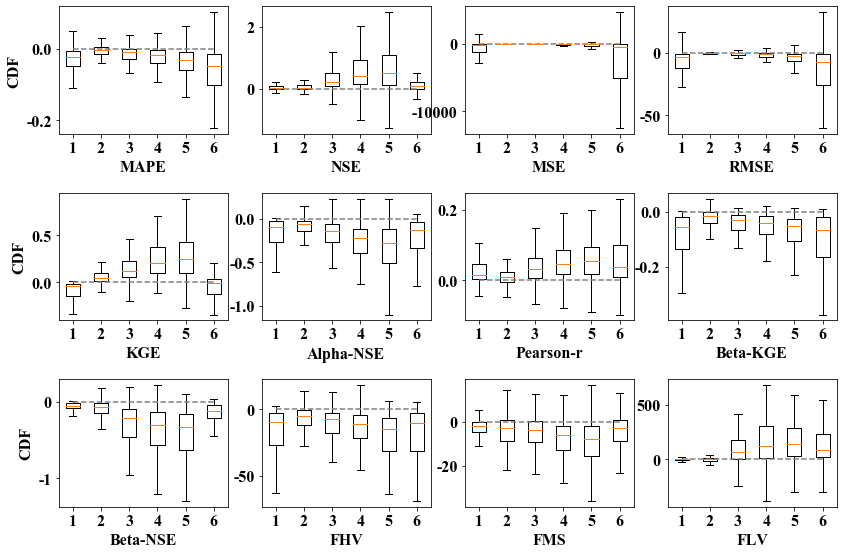

In [118]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    axs[(i)//4,(i)%4].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,i],showfliers=False)
    axs[(i)//4,(i)%4].plot([1,6],[0,0],ls='--',c='grey')

    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

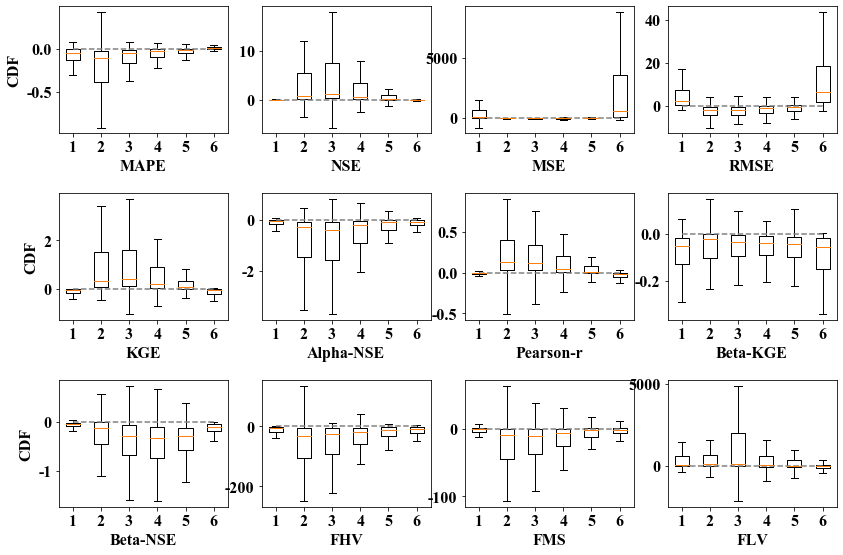

In [119]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    axs[(i)//4,(i)%4].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,i],showfliers=False)
    axs[(i)//4,(i)%4].plot([1,6],[0,0],ls='--',c='grey')

    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

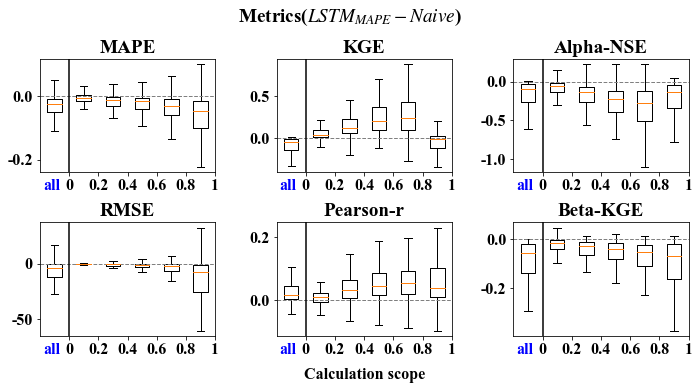

In [317]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((lstm_mapel_indicators_a - lstm_naive_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($LSTM_{MAPE} - Naive$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_MAPE_Naive.jpg',dpi=300)
plt.show()

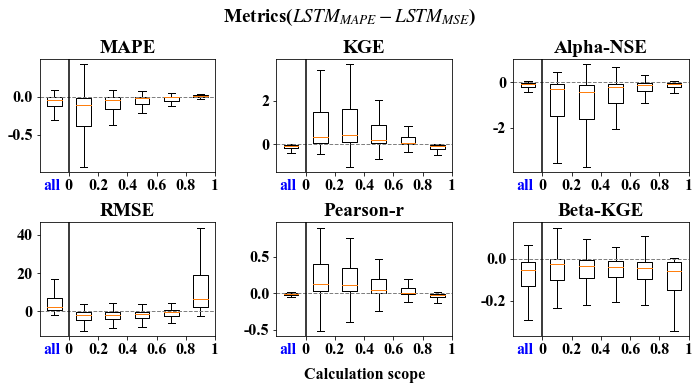

In [318]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((lstm_mapel_indicators_a - lstm_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($LSTM_{MAPE} - LSTM_{MSE}$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_MAPE_LSTM_MSE.jpg',dpi=300)
plt.show()

273


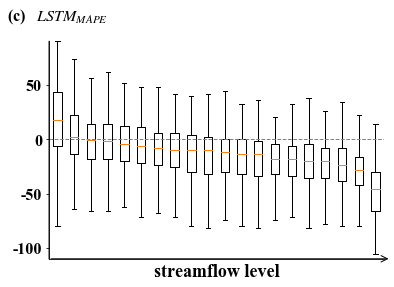

In [319]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_AE = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    ytest = allData[-dayLength:].iloc[10:,0].values
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_ = json.load(f)
    
    lstm_AE.append((ytest_-ytest)[[np.argsort(ytest)]])

lstm_AE = np.array(lstm_AE)

# ============================================
temp = (lstm_AE>0)*2-1
cut = np.arange(0,temp.shape[1],temp.shape[1]//20)
cut[-1] = temp.shape[1]
a=[]
for i in range(len(cut)-1):
    a.append(temp[:,cut[i]:cut[i+1]].sum(1))
    
plt.boxplot(a,showfliers=False)
plt.plot([0.5,20.5],[0,0],lw=1,ls='--',c='grey')
plt.xticks([])
plt.annotate('', 
             xy=(1.02, 0), xycoords='axes fraction',
             xytext=(0, 0), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             zorder=50
            )
plt.annotate('', 
             xy=(0, 1.01), xycoords='axes fraction',
             xytext=(0, -0.01), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-'),
             zorder=50
            )
[plt.gca().spines[loc_axis].set_visible(False) for loc_axis in ['top','right']]
plt.xlabel('streamflow level',fontsize=18)
plt.ylim(-110,90)
plt.text(-2,110,'(c)   $LSTM_{MAPE}$')
plt.savefig(r'F:\objcetive_based_ensemble\figures\balance_c.jpg',dpi=300)
plt.show()

In [320]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_indicators_a = []
lstm_naive_indicators_a = []
lstm_hlbl_indicators_a = []
for ID_i in range(0,len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood_20 = allData.iloc[-dayLength:,0].quantile(0.2)
    low_flood_40 = allData.iloc[-dayLength:,0].quantile(0.4)
    low_flood_60 = allData.iloc[-dayLength:,0].quantile(0.6)
    low_flood_80 = allData.iloc[-dayLength:,0].quantile(0.8)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    ytest_naive_ = ytest[:-1].copy()
    ytest = ytest[1:]
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f))[1:]
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_hlbl_ = np.array(json.load(f))[1:]

    lstm_indicators_a.append([])
    lstm_indicators_a[-1].append(evaluation_indicators(ytest, ytest_))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_[ytest<low_flood_20]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_[ytest>low_flood_80]))
    
    lstm_naive_indicators_a.append([])
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest, ytest_naive_))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_naive_[ytest<low_flood_20]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_naive_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_naive_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_naive_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_naive_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_naive_[ytest>low_flood_80]))
    
    lstm_hlbl_indicators_a.append([])
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest, ytest_hlbl_))
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_hlbl_[ytest<low_flood_20]))
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_hlbl_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_hlbl_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_hlbl_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_hlbl_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_hlbl_[ytest>low_flood_80]))

lstm_indicators_a = np.array(lstm_indicators_a)
lstm_naive_indicators_a = np.array(lstm_naive_indicators_a)
lstm_hlbl_indicators_a = np.array(lstm_hlbl_indicators_a)

273


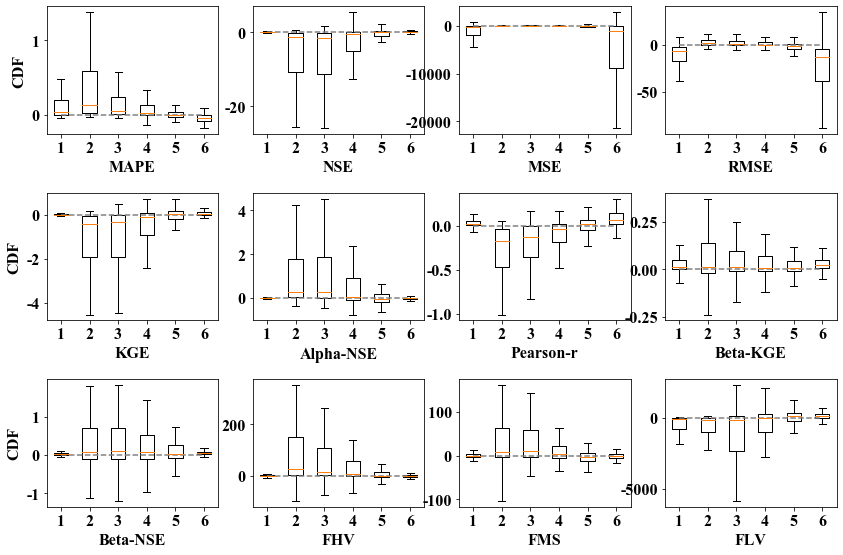

In [124]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    axs[(i)//4,(i)%4].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,i],showfliers=False)
    axs[(i)//4,(i)%4].plot([1,6],[0,0],ls='--',c='grey')

    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

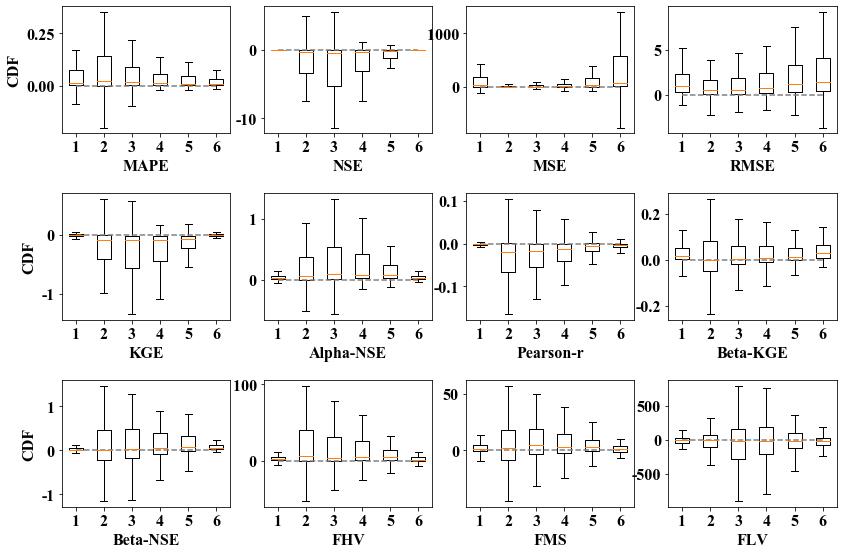

In [125]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    axs[(i)//4,(i)%4].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,i],showfliers=False)
    axs[(i)//4,(i)%4].plot([1,6],[0,0],ls='--',c='grey')

    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

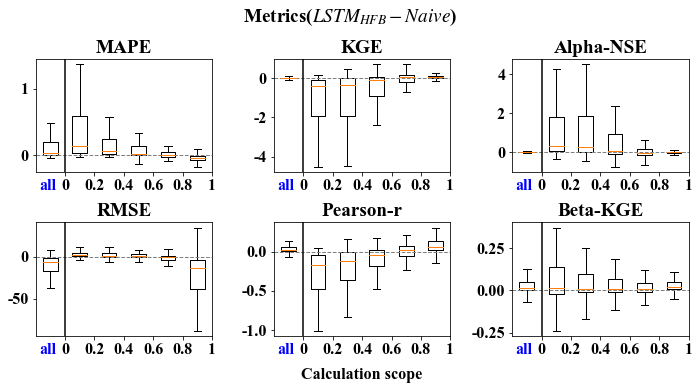

In [321]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((lstm_hlbl_indicators_a - lstm_naive_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($LSTM_{HFB} - Naive$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_HFB_Naive.jpg',dpi=300)
plt.show()

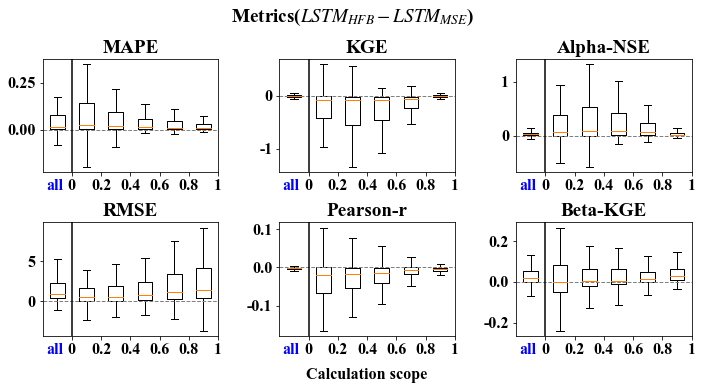

In [322]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((lstm_hlbl_indicators_a - lstm_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($LSTM_{HFB} - LSTM_{MSE}$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_HFB_LSTM_MSE.jpg',dpi=300)
plt.show()

273


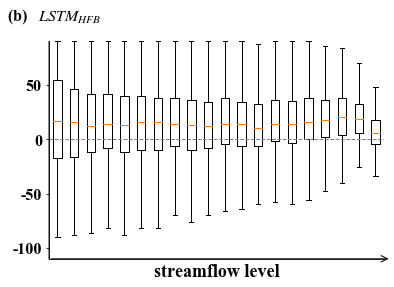

In [323]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_AE = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    ytest = allData[-dayLength:].iloc[10:,0].values
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_ = json.load(f)
    
    lstm_AE.append((ytest_-ytest)[[np.argsort(ytest)]])

lstm_AE = np.array(lstm_AE)

# ============================================
temp = (lstm_AE>0)*2-1
cut = np.arange(0,temp.shape[1],temp.shape[1]//20)
cut[-1] = temp.shape[1]
a=[]
for i in range(len(cut)-1):
    a.append(temp[:,cut[i]:cut[i+1]].sum(1))
    
plt.boxplot(a,showfliers=False)
plt.plot([0.5,20.5],[0,0],lw=1,ls='--',c='grey')
plt.xticks([])
plt.annotate('', 
             xy=(1.02, 0), xycoords='axes fraction',
             xytext=(0, 0), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             zorder=50
            )
plt.annotate('', 
             xy=(0, 1.01), xycoords='axes fraction',
             xytext=(0, -0.01), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-'),
             zorder=50
            )
[plt.gca().spines[loc_axis].set_visible(False) for loc_axis in ['top','right']]
plt.xlabel('streamflow level',fontsize=18)
plt.ylim(-110,90)
plt.text(-2,110,'(b)   $LSTM_{HFB}$')
plt.savefig(r'F:\objcetive_based_ensemble\figures\balance_b.jpg',dpi=300)
plt.show()

In [153]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_mse_indicators_a = []
lstm_mse_indicators_l = []
lstm_mse_indicators_m = []
lstm_mse_indicators_h = []
mlp_mse_indicators_a = []
mlp_mse_indicators_l = []
mlp_mse_indicators_m = []
mlp_mse_indicators_h = []
mlp_mape_indicators_a = []
mlp_mape_indicators_l = []
mlp_mape_indicators_m = []
mlp_mape_indicators_h = []
mlp_hfb_indicators_a = []
mlp_hfb_indicators_l = []
mlp_hfb_indicators_m = []
mlp_hfb_indicators_h = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        lstm_mse_ = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl2\result\ffnn10000\%s.json'%(stationID), 'r') as f:
        mlp_mse_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\ffnn_highLevelBalance\%s.json'%(stationID), 'r') as f:
        mlp_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\ffnn_mre2Loss\%s.json'%(stationID), 'r') as f:
        mlp_mapel_ = np.array(json.load(f))
    
    lstm_mse_indicators_a.append(evaluation_indicators(ytest, lstm_mse_))
    lstm_mse_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], lstm_mse_[ytest<low_flood]))
    lstm_mse_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                   lstm_mse_[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_mse_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood],  lstm_mse_[ytest>high_flood]))
    
    mlp_mse_indicators_a.append(evaluation_indicators(ytest, mlp_mse_))
    mlp_mse_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], mlp_mse_[ytest<low_flood]))
    mlp_mse_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      mlp_mse_[(ytest>=low_flood)&(ytest<=high_flood)]))
    mlp_mse_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], mlp_mse_[ytest>high_flood]))
    
    mlp_mape_indicators_a.append(evaluation_indicators(ytest, mlp_mapel_))
    mlp_mape_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], mlp_mapel_[ytest<low_flood]))
    mlp_mape_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      mlp_mapel_[(ytest>=low_flood)&(ytest<=high_flood)]))
    mlp_mape_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], mlp_mapel_[ytest>high_flood]))
    
    mlp_hfb_indicators_a.append(evaluation_indicators(ytest, mlp_hfbl_))
    mlp_hfb_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], mlp_hfbl_[ytest<low_flood]))
    mlp_hfb_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      mlp_hfbl_[(ytest>=low_flood)&(ytest<=high_flood)]))
    mlp_hfb_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], mlp_hfbl_[ytest>high_flood]))
    

lstm_mse_indicators_a = np.array(lstm_mse_indicators_a)
lstm_mse_indicators_l = np.array(lstm_mse_indicators_l)
lstm_mse_indicators_m = np.array(lstm_mse_indicators_m)
lstm_mse_indicators_h = np.array(lstm_mse_indicators_h)
mlp_mse_indicators_a = np.array(mlp_mse_indicators_a)
mlp_mse_indicators_l = np.array(mlp_mse_indicators_l)
mlp_mse_indicators_m = np.array(mlp_mse_indicators_m)
mlp_mse_indicators_h = np.array(mlp_mse_indicators_h)
mlp_mape_indicators_a = np.array(mlp_mape_indicators_a)
mlp_mape_indicators_l = np.array(mlp_mape_indicators_l)
mlp_mape_indicators_m = np.array(mlp_mape_indicators_m)
mlp_mape_indicators_h = np.array(mlp_mape_indicators_h)
mlp_hfb_indicators_a = np.array(mlp_hfb_indicators_a)
mlp_hfb_indicators_l = np.array(mlp_hfb_indicators_l)
mlp_hfb_indicators_m = np.array(mlp_hfb_indicators_m)
mlp_hfb_indicators_h = np.array(mlp_hfb_indicators_h)

273


低值
0.0478, 4.2819,15.4323, 403.2828
0.0908, 5.4153,17.3813, 406.3926
0.0358, 2.4544,13.5885, 377.3139

-0.0044, 0.8496,0.7767, 0.9932
0.0508, 0.7903,0.7231, 0.9877
0.0704, 0.9095,0.86, 0.9906

-0.5024, 1.0289,1.0677, 7.635
0.5691, 1.0408,1.0803, 3.1199
0.1422, 0.9982,0.9788, 1.1135



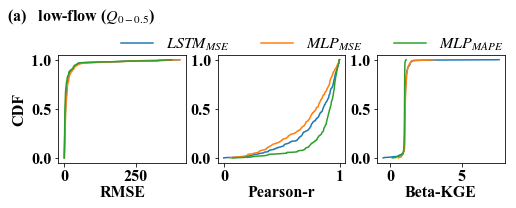

另外加上中位数


In [930]:
print('低值')

def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [3,6,7]

fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(8,3))
for i in range(3):

    Fre_df = CDF_plot(pd.Series(lstm_mse_indicators_l[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    
    Fre_df = CDF_plot(pd.Series(mlp_mse_indicators_l[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$MLP_{MSE}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)
    
    Fre_df = CDF_plot(pd.Series(mlp_mape_indicators_l[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$MLP_{MAPE}$')
    min3 = round(Fre_df['Rds'].min(),4)
    median3 = round(Fre_df['Rds'].median(),4)
    mean3 = round(Fre_df['Rds'].mean(),4)
    max3 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)%3].legend(bbox_to_anchor=(1.1,1.3),ncol=3,frameon=False)
    axs[(i)%3].set_xlabel(temp[choosen[i]],labelpad=1)
    if (i)%3 == 0:
        axs[(i)%3].set_ylabel("CDF")
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)
    print('%s, %s,%s, %s\n%s, %s,%s, %s\n%s, %s,%s, %s\n'%(min1,median1,mean1,max1,min2,median2,mean2,max2,min3,median3,mean3,max3))

axs[0].text(-200,1.4,'(a)   low-flow ($Q_{0-0.5}$)')
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.7, wspace=0.25, hspace=0.45)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\MLP_l.jpg',dpi=300)
plt.show()

print('另外加上中位数')

高值
0.393, 45.801,80.4114, 713.2054
0.4662, 48.6421,84.3236, 741.5487
0.549, 48.7209,87.3644, 760.0408

-0.2922, 0.9097,0.8435, 0.9987
-0.2912, 0.902,0.8369, 0.9988
-0.1403, 0.8952,0.8293, 0.9976

0.4416, 0.9728,0.9469, 1.0294
0.5575, 0.9729,0.9511, 1.0858
0.8323, 0.9978,0.9947, 1.165



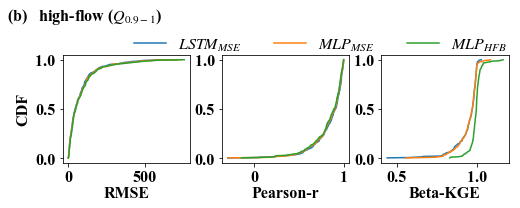

另外加上中位数


In [929]:
print('高值')

def CDF_plot(data):
    denominator=len(data)
    Data=pd.Series(data)
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()
    Fre_df[0]=Fre_df[0]/denominator
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [3,6,7]

fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(8,3))
for i in range(3):

    Fre_df = CDF_plot(pd.Series(lstm_mse_indicators_h[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    
    Fre_df = CDF_plot(pd.Series(mlp_mse_indicators_h[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$MLP_{MSE}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)
    
    Fre_df = CDF_plot(pd.Series(mlp_hfb_indicators_h[:,choosen[i]]))
    axs[(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$MLP_{HFB}$')
    min3 = round(Fre_df['Rds'].min(),4)
    median3 = round(Fre_df['Rds'].median(),4)
    mean3 = round(Fre_df['Rds'].mean(),4)
    max3 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)%3].legend(bbox_to_anchor=(1.1,1.3),ncol=3,frameon=False)
    axs[(i)%3].set_xlabel(temp[choosen[i]],labelpad=1)
    if (i)%3 == 0:
        axs[(i)%3].set_ylabel("CDF")
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)
    print('%s, %s,%s, %s\n%s, %s,%s, %s\n%s, %s,%s, %s\n'%(min1,median1,mean1,max1,min2,median2,mean2,max2,min3,median3,mean3,max3))

axs[0].text(-400,1.4,'(b)   high-flow ($Q_{0.9-1}$)')
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.7, wspace=0.25, hspace=0.45)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\MLP_h.jpg',dpi=300)
plt.show()

print('另外加上中位数')

In [154]:
print('低值的 Beta-KGE 跟1的绝对误差小于0.1的比例:')
print((abs(lstm_mse_indicators_l[:,7]-1)<=0.1).sum(0)/len(lstm_mse_indicators_l))
print((abs(mlp_mape_indicators_l[:,7]-1)<=0.1).sum(0)/len(mlp_mape_indicators_l))

print('\n低值的 Beta-KGE 跟1的绝对误差小于0.05的比例:')
print((abs(lstm_mse_indicators_l[:,7]-1)<=0.05).sum(0)/len(lstm_mse_indicators_l))
print((abs(mlp_mape_indicators_l[:,7]-1)<=0.05).sum(0)/len(mlp_mape_indicators_l))

低值的 Beta-KGE 跟1的绝对误差小于0.1的比例:
0.7289377289377289
0.945054945054945

低值的 Beta-KGE 跟1的绝对误差小于0.05的比例:
0.5457875457875457
0.8937728937728938


In [155]:
print('高值的 Beta-KGE 跟1的绝对误差小于0.1的比例:')
print((abs(lstm_mse_indicators_h[:,7]-1)<=0.1).sum(0)/len(lstm_mse_indicators_h))
print((abs(mlp_hfb_indicators_h[:,7]-1)<=0.1).sum(0)/len(mlp_hfb_indicators_h))

print('\n高值的 Beta-KGE 跟1的绝对误差小于0.05的比例:')
print((abs(lstm_mse_indicators_h[:,7]-1)<=0.05).sum(0)/len(lstm_mse_indicators_h))
print((abs(mlp_hfb_indicators_h[:,7]-1)<=0.05).sum(0)/len(mlp_hfb_indicators_h))

高值的 Beta-KGE 跟1的绝对误差小于0.1的比例:
0.8315018315018315
0.967032967032967

高值的 Beta-KGE 跟1的绝对误差小于0.05的比例:
0.6556776556776557
0.8974358974358975


In [867]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_mse_indicators_a = []
mlp_mse_indicators_a = []
mlp_hfbl_indicators_a = []
mlp_mapel_indicators_a = []
for ID_i in range(0,len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood_20 = allData.iloc[-dayLength:,0].quantile(0.2)
    low_flood_40 = allData.iloc[-dayLength:,0].quantile(0.4)
    low_flood_60 = allData.iloc[-dayLength:,0].quantile(0.6)
    low_flood_80 = allData.iloc[-dayLength:,0].quantile(0.8)
    
    ytest = allData[-dayLength:].iloc[10:,0].values

    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl2\result\ffnn10000\%s.json'%(stationID), 'r') as f:
        mlp_mse_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\ffnn_highLevelBalance\%s.json'%(stationID), 'r') as f:
        mlp_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\ffnn_mre2Loss\%s.json'%(stationID), 'r') as f:
        mlp_mapel_ = np.array(json.load(f))

    lstm_mse_indicators_a.append([])
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest, ytest_))
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], ytest_[ytest<low_flood_20]))
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   ytest_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   ytest_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   ytest_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    lstm_mse_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], ytest_[ytest>low_flood_80]))
    
    mlp_mse_indicators_a.append([])
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest, mlp_mse_))
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], mlp_mse_[ytest<low_flood_20]))
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   mlp_mse_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   mlp_mse_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   mlp_mse_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    mlp_mse_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], mlp_mse_[ytest>low_flood_80]))
    
    mlp_hfbl_indicators_a.append([])
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest, mlp_hfbl_))
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], mlp_hfbl_[ytest<low_flood_20]))
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   mlp_hfbl_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   mlp_hfbl_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   mlp_hfbl_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    mlp_hfbl_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], mlp_hfbl_[ytest>low_flood_80]))
    
    mlp_mapel_indicators_a.append([])
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest, mlp_mapel_))
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest[ytest<low_flood_20], mlp_mapel_[ytest<low_flood_20]))
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_20)&(ytest<=low_flood_40)], 
                                                   mlp_mapel_[(ytest>=low_flood_20)&(ytest<=low_flood_40)]))
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_40)&(ytest<=low_flood_60)], 
                                                   mlp_mapel_[(ytest>=low_flood_40)&(ytest<=low_flood_60)]))
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest[(ytest>=low_flood_60)&(ytest<=low_flood_80)], 
                                                   mlp_mapel_[(ytest>=low_flood_60)&(ytest<=low_flood_80)]))
    mlp_mapel_indicators_a[-1].append(evaluation_indicators(ytest[ytest>low_flood_80], mlp_mapel_[ytest>low_flood_80]))

lstm_mse_indicators_a = np.array(lstm_mse_indicators_a)
mlp_mse_indicators_a = np.array(mlp_mse_indicators_a)
mlp_hfbl_indicators_a = np.array(mlp_hfbl_indicators_a)
mlp_mapel_indicators_a = np.array(mlp_mapel_indicators_a)

273


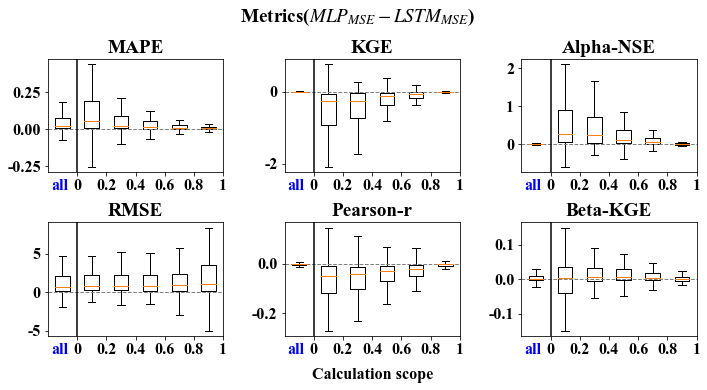

In [868]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((mlp_mse_indicators_a - lstm_mse_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($MLP_{MSE} - LSTM_{MSE}$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
# plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_HFB_LSTM_MSE.jpg',dpi=300)
plt.show()

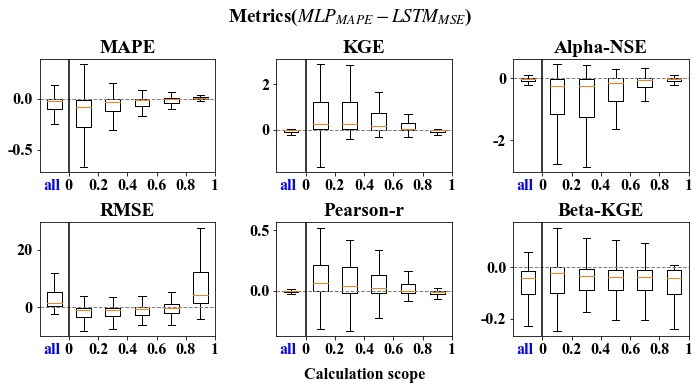

In [870]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((mlp_mapel_indicators_a - lstm_mse_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($MLP_{MAPE} - LSTM_{MSE}$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
# plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_HFB_LSTM_MSE.jpg',dpi=300)
plt.show()

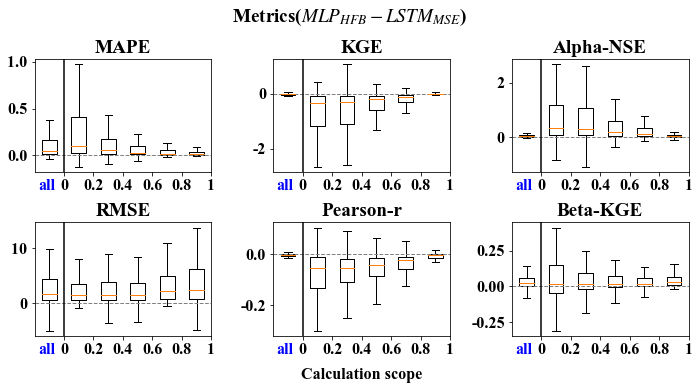

In [869]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(10,5.5))

axs[0,0].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,0],showfliers=False)
axs[0,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,0].set_title(temp[0])
axs[0,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,0].set_ylim(axs[0,0].get_ylim())
axs[0,0].plot([1.5,1.5],axs[0,0].get_ylim(),c='k')
axs[0,0].get_xticklabels()[0].set_color('blue')
axs[0,0].xaxis.get_ticklines()[0].set_color('w')

axs[1,0].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,3],showfliers=False)
axs[1,0].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,0].set_title(temp[3])
axs[1,0].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,0].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,0].set_ylim(axs[1,0].get_ylim())
axs[1,0].plot([1.5,1.5],axs[1,0].get_ylim(),c='k')
axs[1,0].get_xticklabels()[0].set_color('blue')
axs[1,0].xaxis.get_ticklines()[0].set_color('w')

axs[0,1].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,4],showfliers=False)
axs[0,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,1].set_title(temp[4])
axs[0,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,1].set_ylim(axs[0,1].get_ylim())
axs[0,1].plot([1.5,1.5],axs[0,1].get_ylim(),c='k')
axs[0,1].get_xticklabels()[0].set_color('blue')
axs[0,1].xaxis.get_ticklines()[0].set_color('w')

axs[1,1].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,6],showfliers=False)
axs[1,1].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,1].set_title(temp[6])
axs[1,1].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,1].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,1].set_ylim(axs[1,1].get_ylim())
axs[1,1].plot([1.5,1.5],axs[1,1].get_ylim(),c='k')
axs[1,1].get_xticklabels()[0].set_color('blue')
axs[1,1].xaxis.get_ticklines()[0].set_color('w')

axs[0,2].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,5],showfliers=False)
axs[0,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[0,2].set_title(temp[5])
axs[0,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[0,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[0,2].set_ylim(axs[0,2].get_ylim())
axs[0,2].plot([1.5,1.5],axs[0,2].get_ylim(),c='k')
axs[0,2].get_xticklabels()[0].set_color('blue')
axs[0,2].xaxis.get_ticklines()[0].set_color('w')

axs[1,2].boxplot((mlp_hfbl_indicators_a - lstm_mse_indicators_a)[:,:,7],showfliers=False)
axs[1,2].plot([0.5,6.5],[0,0],ls='--',c='grey',lw=1)
axs[1,2].set_title(temp[7])
axs[1,2].set_xticks([0.9,1.5,2.5,3.5,4.5,5.5,6.5])
axs[1,2].set_xticklabels(['all','0','0.2','0.4','0.6','0.8','1'])
axs[1,2].set_ylim(axs[1,2].get_ylim())
axs[1,2].plot([1.5,1.5],axs[1,2].get_ylim(),c='k')
axs[1,2].get_xticklabels()[0].set_color('blue')
axs[1,2].xaxis.get_ticklines()[0].set_color('w')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
# plt.tight_layout()
axs[1,1].set_xlabel('Calculation scope',labelpad=10)
plt.suptitle(t='Metrics($MLP_{HFB} - LSTM_{MSE}$)')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.85, wspace=0.35, hspace=None)
# plt.tight_layout()
# plt.savefig(r'F:\objcetive_based_ensemble\figures\LSTM_HFB_LSTM_MSE.jpg',dpi=300)
plt.show()

In [124]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

naive_indicators_a = []
lstm_indicators_a = []
lstm_indicators_l = []
lstm_indicators_m = []
lstm_indicators_h = []
lstm_dl_indicators_a = []
lstm_dl_indicators_l = []
lstm_dl_indicators_m = []
lstm_dl_indicators_h = []
lstm_mape_indicators_a = []
lstm_mape_indicators_l = []
lstm_mape_indicators_m = []
lstm_mape_indicators_h = []
lstm_mape_hlbl_indicators_a = []
lstm_mape_hlbl_indicators_l = []
lstm_mape_hlbl_indicators_m = []
lstm_mape_hlbl_indicators_h = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    ytest_naive_ = ytest[:-1].copy()
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance_mreloss2\%s.json'%(stationID), 'r') as f:
        ytest_mape_hlbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_lstm = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_l = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_h = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.5_0.9\%s.json'%(stationID), 'r') as f:
        ytestSL_ = np.array(json.load(f))
        
    ytest_ = ytest_lstm.copy()
    ytest_[ytestSL_==1] = ytest_l[ytestSL_==1]
    ytest_[ytestSL_==3] = ytest_h[ytestSL_==3]
    
    naive_indicators_a.append(evaluation_indicators(ytest[1:], ytest_naive_))
    
    lstm_indicators_a.append(evaluation_indicators(ytest, ytest_lstm))
    lstm_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_lstm[ytest<low_flood]))
    lstm_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                   ytest_lstm[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood],  ytest_lstm[ytest>high_flood]))
    
    lstm_dl_indicators_a.append(evaluation_indicators(ytest, ytest_))
    lstm_dl_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_[ytest<low_flood]))
    lstm_dl_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      ytest_[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_dl_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], ytest_[ytest>high_flood]))
    
    lstm_mape_indicators_a.append(evaluation_indicators(ytest, ytest_l))
    lstm_mape_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_l[ytest<low_flood]))
    lstm_mape_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      ytest_l[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_mape_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], ytest_l[ytest>high_flood]))
    
    lstm_mape_hlbl_indicators_a.append(evaluation_indicators(ytest, ytest_mape_hlbl_))
    lstm_mape_hlbl_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_mape_hlbl_[ytest<low_flood]))
    lstm_mape_hlbl_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      ytest_mape_hlbl_[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_mape_hlbl_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], ytest_mape_hlbl_[ytest>high_flood]))
    
naive_indicators_a = np.array(naive_indicators_a)
lstm_indicators_a = np.array(lstm_indicators_a)
lstm_indicators_l = np.array(lstm_indicators_l)
lstm_indicators_m = np.array(lstm_indicators_m)
lstm_indicators_h = np.array(lstm_indicators_h)
lstm_dl_indicators_a = np.array(lstm_dl_indicators_a)
lstm_dl_indicators_l = np.array(lstm_dl_indicators_l)
lstm_dl_indicators_m = np.array(lstm_dl_indicators_m)
lstm_dl_indicators_h = np.array(lstm_dl_indicators_h)
lstm_mape_indicators_a = np.array(lstm_mape_indicators_a)
lstm_mape_indicators_l = np.array(lstm_mape_indicators_l)
lstm_mape_indicators_m = np.array(lstm_mape_indicators_m)
lstm_mape_indicators_h = np.array(lstm_mape_indicators_h)
lstm_mape_hlbl_indicators_a = np.array(lstm_mape_hlbl_indicators_a)
lstm_mape_hlbl_indicators_l = np.array(lstm_mape_hlbl_indicators_l)
lstm_mape_hlbl_indicators_m = np.array(lstm_mape_hlbl_indicators_m)
lstm_mape_hlbl_indicators_h = np.array(lstm_mape_hlbl_indicators_h)

273


全部


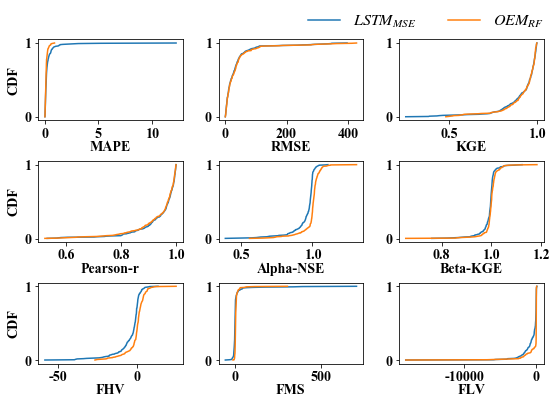

另外加上中位数


In [147]:
print('全部')

def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [0,3,4,6,5,7,9,10,11]

fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(8,6))
for i in range(9):

    Fre_df = CDF_plot(pd.Series(lstm_indicators_a[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    Fre_df = CDF_plot(pd.Series(lstm_dl_indicators_a[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$OEM_{RF}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)//3,(i)%3].legend(bbox_to_anchor=(1.1,1.5),ncol=2,frameon=False)
    axs[(i)//3,(i)%3].set_xlabel(temp[choosen[i]],labelpad=0.1,fontsize=14)
    if (i)%3 == 0:
        axs[(i)//3,(i)%3].set_ylabel("CDF",fontsize=14)
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_xticklabels()]
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_yticklabels()]
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.5)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\OEM_MSE_a_yuan.jpg',dpi=300)
plt.show()

print('另外加上中位数')

高值


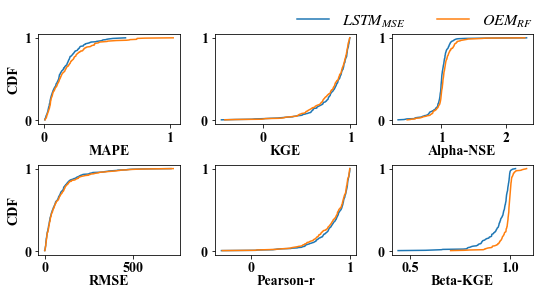

另外加上中位数


In [149]:
print('高值')

def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [0,4,5,3,6,7]

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(8,4.5))
for i in range(6):

    Fre_df = CDF_plot(pd.Series(lstm_indicators_h[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    Fre_df = CDF_plot(pd.Series(lstm_dl_indicators_h[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$OEM_{RF}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)//3,(i)%3].legend(bbox_to_anchor=(1.1,1.39),ncol=2,frameon=False)
    axs[(i)//3,(i)%3].set_xlabel(temp[choosen[i]],labelpad=0.1,fontsize=14)
    if (i)%3 == 0:
        axs[(i)//3,(i)%3].set_ylabel("CDF",fontsize=14)
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_xticklabels()]
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_yticklabels()]
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\OEM_MSE_h_yuan.jpg',dpi=300)
plt.show()

print('另外加上中位数')

中值


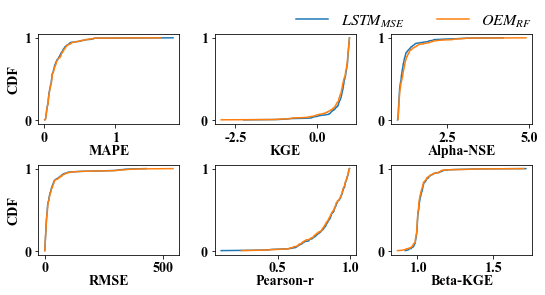

另外加上中位数


In [150]:
print('中值')

def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [0,4,5,3,6,7]

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(8,4.5))
for i in range(6):

    Fre_df = CDF_plot(pd.Series(lstm_indicators_m[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    Fre_df = CDF_plot(pd.Series(lstm_dl_indicators_m[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$OEM_{RF}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)//3,(i)%3].legend(bbox_to_anchor=(1.1,1.39),ncol=2,frameon=False)
    axs[(i)//3,(i)%3].set_xlabel(temp[choosen[i]],labelpad=0.1,fontsize=14)
    if (i)%3 == 0:
        axs[(i)//3,(i)%3].set_ylabel("CDF",fontsize=14)
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_xticklabels()]
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_yticklabels()]
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\OEM_MSE_m_yuan.jpg',dpi=300)
plt.show()

print('另外加上中位数')

低值


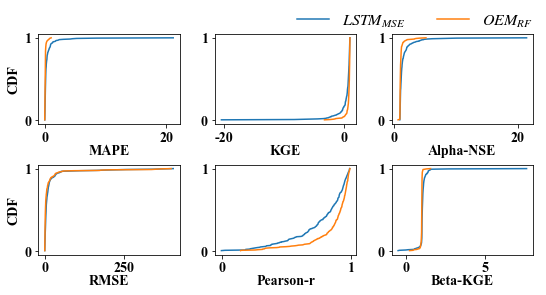

另外加上中位数


In [151]:
print('低值')

def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
choosen = [0,4,5,3,6,7]

fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(8,4.5))
for i in range(6):

    Fre_df = CDF_plot(pd.Series(lstm_indicators_l[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$LSTM_{MSE}$')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4)
    Fre_df = CDF_plot(pd.Series(lstm_dl_indicators_l[:,choosen[i]]))
    axs[(i)//3,(i)%3].plot(Fre_df['Rds'],Fre_df['cumsum'],label='$OEM_{RF}$')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)

    if i == 2:
        axs[(i)//3,(i)%3].legend(bbox_to_anchor=(1.1,1.39),ncol=2,frameon=False)
    axs[(i)//3,(i)%3].set_xlabel(temp[choosen[i]],labelpad=0.1,fontsize=14)
    if (i)%3 == 0:
        axs[(i)//3,(i)%3].set_ylabel("CDF",fontsize=14)
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_xticklabels()]
    [i.set_fontsize(14) for i in axs[(i)//3,(i)%3].get_yticklabels()]
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
#     axs[(i)//3,(i)%3].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45)
# plt.tight_layout()
plt.savefig(r'F:\objcetive_based_ensemble\figures\OEM_MSE_l_yuan.jpg',dpi=300)
plt.show()

print('另外加上中位数')

273


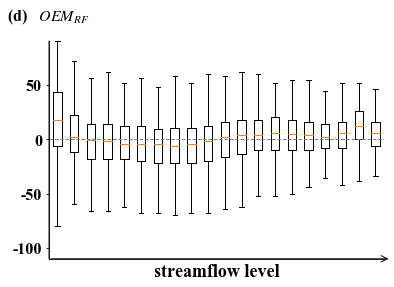

In [125]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_AE = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_lstm = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_l = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_h = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.5_0.9\%s.json'%(stationID), 'r') as f:
        ytestSL_ = np.array(json.load(f))
        
    ytest_ = ytest_lstm.copy()
    ytest_[ytestSL_==1] = ytest_l[ytestSL_==1]
    ytest_[ytestSL_==3] = ytest_h[ytestSL_==3]
    
    lstm_AE.append((ytest_-ytest)[[np.argsort(ytest)]])

lstm_AE = np.array(lstm_AE)

# ============================================
temp = (lstm_AE>0)*2-1
cut = np.arange(0,temp.shape[1],temp.shape[1]//20)
cut[-1] = temp.shape[1]
a=[]
for i in range(len(cut)-1):
    a.append(temp[:,cut[i]:cut[i+1]].sum(1))
    
plt.boxplot(a,showfliers=False)
plt.plot([0.5,20.5],[0,0],lw=1,ls='--',c='grey')
plt.xticks([])
plt.annotate('', 
             xy=(1.02, 0), xycoords='axes fraction',
             xytext=(0, 0), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             zorder=50
            )
plt.annotate('', 
             xy=(0, 1.01), xycoords='axes fraction',
             xytext=(0, -0.01), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-'),
             zorder=50
            )
[plt.gca().spines[loc_axis].set_visible(False) for loc_axis in ['top','right']]
plt.xlabel('streamflow level',fontsize=18)
plt.ylim(-110,90)
plt.text(-2,110,'(d)   $OEM_{RF}$')
plt.savefig(r'F:\研究生相关\科研\objcetive_based_ensemble\figures\balance_d.jpg',dpi=300)
plt.show()

In [ ]:
temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

In [632]:
print('MAPE, RMSE, KGE, Pearson-r 这四个指标比 naive方法好的比例:\n')

print((lstm_indicators_a[:,[0,3,4,6]]>naive_indicators_a[:,[0,3,4,6]]).sum(0)/len(naive_indicators_a))
print((lstm_dl_indicators_a[:,[0,3,4,6]]>naive_indicators_a[:,[0,3,4,6]]).sum(0)/len(naive_indicators_a))

MAPE, RMSE, KGE, Pearson-r 这四个指标比 naive方法好的比例:

[0.57875458 0.01465201 0.70695971 0.98168498]
[0.24908425 0.05128205 0.73626374 0.96336996]


In [637]:
print('Alpha-NSE, Beta-KGE 跟1的绝对误差小于0.1的比例:')
print((abs(lstm_indicators_a[:,[5,7]]-1)<=0.1).sum(0)/len(lstm_indicators_a))
print((abs(lstm_dl_indicators_a[:,[5,7]]-1)<=0.1).sum(0)/len(lstm_dl_indicators_a))

print('\nAlpha-NSE, Beta-KGE 跟1的绝对误差小于0.05的比例:')
print((abs(lstm_indicators_a[:,[5,7]]-1)<=0.05).sum(0)/len(lstm_indicators_a))
print((abs(lstm_dl_indicators_a[:,[5,7]]-1)<=0.05).sum(0)/len(lstm_dl_indicators_a))

Alpha-NSE, Beta-KGE 跟1的绝对误差小于0.1的比例:
[0.86446886 0.97069597]
[0.90842491 0.98168498]

Alpha-NSE, Beta-KGE 跟1的绝对误差小于0.05的比例:
[0.73992674 0.91575092]
[0.79487179 0.94505495]


In [638]:
print('FHV, FMS, FLV 跟0的绝对误差小于10的比例:\n')

print((abs(lstm_indicators_a[:,-3:])<=10).sum(0)/len(lstm_indicators_a))
print((abs(lstm_dl_indicators_a[:,-3:])<=10).sum(0)/len(lstm_dl_indicators_a))

FHV, FMS, FLV 跟0的绝对误差小于10的比例:

[0.86446886 0.84249084 0.18315018]
[0.91941392 0.89010989 0.56410256]


In [639]:
print('FHV 大于0的比例:\n')

print((lstm_indicators_a[:,-3]>=0).sum(0)/len(lstm_indicators_a))
print((lstm_dl_indicators_a[:,-3]>=0).sum(0)/len(lstm_indicators_a))

FHV 大于0的比例:

0.24175824175824176
0.5384615384615384


In [641]:
print('高值的 Beta-KGE 跟1的绝对误差小于0.1的比例:')
print((abs(lstm_indicators_h[:,7]-1)<=0.1).sum(0)/len(lstm_indicators_h))
print((abs(lstm_dl_indicators_h[:,7]-1)<=0.1).sum(0)/len(lstm_dl_indicators_h))

print('\n高值的 Beta-KGE 跟1的绝对误差小于0.05的比例:')
print((abs(lstm_indicators_h[:,7]-1)<=0.05).sum(0)/len(lstm_indicators_h))
print((abs(lstm_dl_indicators_h[:,7]-1)<=0.05).sum(0)/len(lstm_dl_indicators_h))

高值的 Beta-KGE 跟1的绝对误差小于0.1的比例:
0.8315018315018315
0.9633699633699634

高值的 Beta-KGE 跟1的绝对误差小于0.05的比例:
0.6556776556776557
0.8681318681318682


In [642]:
print('高值的 Beta-KGE 大于1的比例:\n')

print((lstm_indicators_h[:,7]>=1).sum(0)/len(lstm_indicators_h))
print((lstm_dl_indicators_h[:,7]>=1).sum(0)/len(lstm_indicators_h))

高值的 Beta-KGE 大于1的比例:

0.07326007326007326
0.3882783882783883


In [156]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_outMeanMax_indicators_l = []
lstm_outMeanMax_indicators_h = []
lstm_outMeanMax_dl_indicators_l = []
lstm_outMeanMax_dl_indicators_h = []
lstm_outMeanMin_indicators_l = []
lstm_outMeanMin_indicators_h = []
lstm_outMeanMin_dl_indicators_l = []
lstm_outMeanMin_dl_indicators_h = []
lstm_outStdMax_indicators_l = []
lstm_outStdMax_indicators_h = []
lstm_outStdMax_dl_indicators_l = []
lstm_outStdMax_dl_indicators_h = []
lstm_outStdMin_indicators_l = []
lstm_outStdMin_indicators_h = []
lstm_outStdMin_dl_indicators_l = []
lstm_outStdMin_dl_indicators_h = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')
    
    year_average = allData[0].resample('1Y').mean()
    year_average_max = year_average.iloc[:32].max()
    year_average_min = year_average.iloc[:32].min()

    year_std = allData[0].resample('1Y').std()
    year_std_max = year_std.iloc[:32].max()
    year_std_min = year_std.iloc[:32].min()
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_lstm = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_l = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_h = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.5_0.9\%s.json'%(stationID), 'r') as f:
        ytestSL_ = np.array(json.load(f))
        
    ytest_ = ytest_lstm.copy()
    ytest_[ytestSL_==1] = ytest_l[ytestSL_==1]
    ytest_[ytestSL_==3] = ytest_h[ytestSL_==3]
    
    
    temp = pd.DataFrame(data = [np.nan]*1816,index = pd.date_range('2014-01-11','2018-12-31', freq='1D'))
    for i in range(2014,2019):
        temp.loc[str(i),0] = year_average.loc[str(i)].values      
    chosen = (temp>year_average_max).values.reshape(-1,)
    if ((ytest<low_flood)&chosen).sum() > 3:
        lstm_outMeanMax_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_lstm[(ytest<low_flood)&chosen]))
        lstm_outMeanMax_dl_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_[(ytest<low_flood)&chosen]))
    if ((ytest>high_flood)&chosen).sum() > 3:
        lstm_outMeanMax_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_lstm[(ytest>high_flood)&chosen]))        
        lstm_outMeanMax_dl_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_[(ytest>high_flood)&chosen]))
        
    temp = pd.DataFrame(data = [np.nan]*1816,index = pd.date_range('2014-01-11','2018-12-31', freq='1D'))
    for i in range(2014,2019):
        temp.loc[str(i),0] = year_average.loc[str(i)].values      
    chosen = (temp<year_average_min).values.reshape(-1,)
    if ((ytest<low_flood)&chosen).sum() > 3:
        lstm_outMeanMin_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_lstm[(ytest<low_flood)&chosen]))
        lstm_outMeanMin_dl_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_[(ytest<low_flood)&chosen]))
    if ((ytest>high_flood)&chosen).sum() > 3:
        lstm_outMeanMin_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_lstm[(ytest>high_flood)&chosen]))        
        lstm_outMeanMin_dl_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_[(ytest>high_flood)&chosen]))
        
    temp = pd.DataFrame(data = [np.nan]*1816,index = pd.date_range('2014-01-11','2018-12-31', freq='1D'))
    for i in range(2014,2019):
        temp.loc[str(i),0] = year_average.loc[str(i)].values      
    chosen = (temp>year_std_max).values.reshape(-1,)
    if ((ytest<low_flood)&chosen).sum() > 3:
        lstm_outStdMax_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_lstm[(ytest<low_flood)&chosen]))
        lstm_outStdMax_dl_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_[(ytest<low_flood)&chosen]))
    if ((ytest>high_flood)&chosen).sum() > 3:
        lstm_outStdMax_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_lstm[(ytest>high_flood)&chosen]))        
        lstm_outStdMax_dl_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_[(ytest>high_flood)&chosen]))
        
    temp = pd.DataFrame(data = [np.nan]*1816,index = pd.date_range('2014-01-11','2018-12-31', freq='1D'))
    for i in range(2014,2019):
        temp.loc[str(i),0] = year_average.loc[str(i)].values      
    chosen = (temp<year_std_min).values.reshape(-1,)
    if ((ytest<low_flood)&chosen).sum() > 3:
        lstm_outStdMin_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_lstm[(ytest<low_flood)&chosen]))
        lstm_outStdMin_dl_indicators_l.append(evaluation_indicators(ytest[(ytest<low_flood)&chosen], ytest_[(ytest<low_flood)&chosen]))
    if ((ytest>high_flood)&chosen).sum() > 3:
        lstm_outStdMin_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_lstm[(ytest>high_flood)&chosen]))        
        lstm_outStdMin_dl_indicators_h.append(evaluation_indicators(ytest[(ytest>high_flood)&chosen], ytest_[(ytest>high_flood)&chosen]))
    
    
lstm_outMeanMax_indicators_l = np.array(lstm_outMeanMax_indicators_l)
lstm_outMeanMax_indicators_h = np.array(lstm_outMeanMax_indicators_h)
lstm_outMeanMax_dl_indicators_l = np.array(lstm_outMeanMax_dl_indicators_l)
lstm_outMeanMax_dl_indicators_h = np.array(lstm_outMeanMax_dl_indicators_h)
lstm_outMeanMin_indicators_l = np.array(lstm_outMeanMin_indicators_l)
lstm_outMeanMin_indicators_h = np.array(lstm_outMeanMin_indicators_h)
lstm_outMeanMin_dl_indicators_l = np.array(lstm_outMeanMin_dl_indicators_l)
lstm_outMeanMin_dl_indicators_h = np.array(lstm_outMeanMin_dl_indicators_h)
lstm_outStdMax_indicators_l = np.array(lstm_outStdMax_indicators_l)
lstm_outStdMax_indicators_h = np.array(lstm_outStdMax_indicators_h)
lstm_outStdMax_dl_indicators_l = np.array(lstm_outStdMax_dl_indicators_l)
lstm_outStdMax_dl_indicators_h = np.array(lstm_outStdMax_dl_indicators_h)
lstm_outStdMin_indicators_l = np.array(lstm_outStdMin_indicators_l)
lstm_outStdMin_indicators_h = np.array(lstm_outStdMin_indicators_h)
lstm_outStdMin_dl_indicators_l = np.array(lstm_outStdMin_dl_indicators_l)
lstm_outStdMin_dl_indicators_h = np.array(lstm_outStdMin_dl_indicators_h)

273


In [164]:
print('lstm_outMeanMax_indicators_l',lstm_outMeanMax_indicators_l.shape)
print(pd.DataFrame(lstm_outMeanMax_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outMeanMax_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outMeanMin_indicators_l',lstm_outMeanMin_indicators_l.shape)
print(pd.DataFrame(lstm_outMeanMin_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outMeanMin_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outStdMax_indicators_l',lstm_outStdMax_indicators_l.shape)
print(pd.DataFrame(lstm_outStdMax_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outStdMax_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outStdMin_indicators_l',lstm_outStdMin_indicators_l.shape)
print(pd.DataFrame(lstm_outStdMin_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outStdMin_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])

print('lstm_outMeanMax_indicators_h',lstm_outMeanMax_indicators_h.shape)
print(pd.DataFrame(lstm_outMeanMax_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outMeanMax_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outMeanMin_indicators_h',lstm_outMeanMin_indicators_h.shape)
print(pd.DataFrame(lstm_outMeanMin_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outMeanMin_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outStdMax_indicators_h',lstm_outStdMax_indicators_h.shape)
print(pd.DataFrame(lstm_outStdMax_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outStdMax_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print('lstm_outStdMin_indicators_h',lstm_outStdMin_indicators_h.shape)
print(pd.DataFrame(lstm_outStdMin_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])
print(pd.DataFrame(lstm_outStdMin_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]])

lstm_outMeanMax_indicators_l (39, 12)
MAPE         0.104241
RMSE         3.452730
KGE          0.572932
Alpha-NSE    1.249151
Pearson-r    0.792863
Beta-KGE     1.014514
dtype: float64
MAPE         0.060468
RMSE         1.536638
KGE          0.823112
Alpha-NSE    1.097529
Pearson-r    0.904659
Beta-KGE     0.996259
dtype: float64
lstm_outMeanMin_indicators_l (15, 12)
MAPE         0.361030
RMSE         3.095097
KGE          0.719144
Alpha-NSE    1.140944
Pearson-r    0.900552
Beta-KGE     1.036708
dtype: float64
MAPE         0.123620
RMSE         1.466601
KGE          0.921505
Alpha-NSE    1.012565
Pearson-r    0.932095
Beta-KGE     1.008473
dtype: float64
lstm_outStdMax_indicators_l (51, 12)
MAPE         0.055326
RMSE         8.720603
KGE          0.818408
Alpha-NSE    1.109948
Pearson-r    0.879910
Beta-KGE     1.013833
dtype: float64
MAPE         0.046304
RMSE         8.284074
KGE          0.857531
Alpha-NSE    1.067572
Pearson-r    0.896569
Beta-KGE     1.000145
dtype: float64
lstm_

In [165]:
result = []
print('lstm_outMeanMax_indicators_l')
result.append(pd.DataFrame(lstm_outMeanMax_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outMeanMax_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outMeanMin_indicators_l')
result.append(pd.DataFrame(lstm_outMeanMin_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outMeanMin_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outStdMax_indicators_l')
result.append(pd.DataFrame(lstm_outStdMax_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outStdMax_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outStdMin_indicators_l')
result.append(pd.DataFrame(lstm_outStdMin_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outStdMin_dl_indicators_l,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)

print('lstm_outMeanMax_indicators_h')
result.append(pd.DataFrame(lstm_outMeanMax_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outMeanMax_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outMeanMin_indicators_h')
result.append(pd.DataFrame(lstm_outMeanMin_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outMeanMin_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outStdMax_indicators_h')
result.append(pd.DataFrame(lstm_outStdMax_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outStdMax_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
print('lstm_outStdMin_indicators_h')
result.append(pd.DataFrame(lstm_outStdMin_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)
result.append(pd.DataFrame(lstm_outStdMin_dl_indicators_h,
             columns=['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
            ).median()[[0,3,4,5,6,7]].values)

print('保持结果到excel')
pd.DataFrame(np.array(result)).to_excel(r'F:\objcetive_based_ensemble\figures\metrics.xlsx')

lstm_outMeanMax_indicators_l
lstm_outMeanMin_indicators_l
lstm_outStdMax_indicators_l
lstm_outStdMin_indicators_l
lstm_outMeanMax_indicators_h
lstm_outMeanMin_indicators_h
lstm_outStdMax_indicators_h
lstm_outStdMin_indicators_h
保持结果到excel


In [22]:
CM_indicators = []
CM_LSTM_indicators = []
CMtoLSTM_indicator = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]

    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    xtrain = []
    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        xtrain.append(trainData.iloc[i:i+lag,:].values)
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    xtrain = np.array(xtrain, dtype=np.float32)   
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1, 1)
   
    xtest = []
    ytest = []
    for i in range(len(testData)-lag-(ahead-1)):
        xtest.append(testData.iloc[i:i+lag,:].values)
        ytest.append(testData.iloc[i+lag+(ahead-1),0])
    xtest = np.array(xtest, dtype=np.float32)   
    ytest = np.array(ytest, dtype=np.float32).reshape(-1, 1)
    
    
    bounds = [0,pd.Series(ytrain.reshape(-1,)).quantile(0.5),pd.Series(ytrain.reshape(-1,)).quantile(0.9)]
    ytrainSL = np.array(bounds).reshape(1,-1).repeat(len(ytrain),0)
    ytrainSL = (ytrainSL<=ytrain).sum(1)
    ytestSL = np.array(bounds).reshape(1,-1).repeat(len(ytest),0)
    ytestSL = (ytestSL<=ytest).sum(1)
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f)).reshape(-1, 1)
    ytest_[ytest_<0] = 0  # 预测值有小于0的
    ytestSL_lstm_ = np.array(bounds).reshape(1,-1).repeat(len(ytest_),0)
    ytestSL_lstm_ = (ytestSL_lstm_<=ytest_).sum(1)
    CM_LSTM_indicators.append(evaluation_indicators_classification(ytestSL, ytestSL_lstm_))
    ytestSL_lstm_ = (ytestSL_lstm_ - ytestSL) != 0

    CM_indicators.append([])
    CMtoLSTM_indicator.append([])
    CMs = ['RF', 'MLP','LR','KNN','SVM']
    for CM in CMs:
        with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\%s_SL_0.5_0.9\%s.json'%(CM,stationID), 'r') as f:
            ytestSL_ = json.load(f)

        CM_indicators[-1].append(evaluation_indicators_classification(ytestSL, ytestSL_))
        
        CMtoLSTM_indicator[-1].append([(ytestSL_lstm_ & ((ytestSL_ - ytestSL) != 0)).sum() / ((ytestSL_ - ytestSL) != 0).sum(), 
                                       (ytestSL_lstm_ & ((ytestSL_ - ytestSL) != 0)).sum() / ytestSL_lstm_.sum()])
    
CM_indicators = np.array(CM_indicators)
CM_LSTM_indicators = np.array(CM_LSTM_indicators)
CMtoLSTM_indicator = np.array(CMtoLSTM_indicator)

273


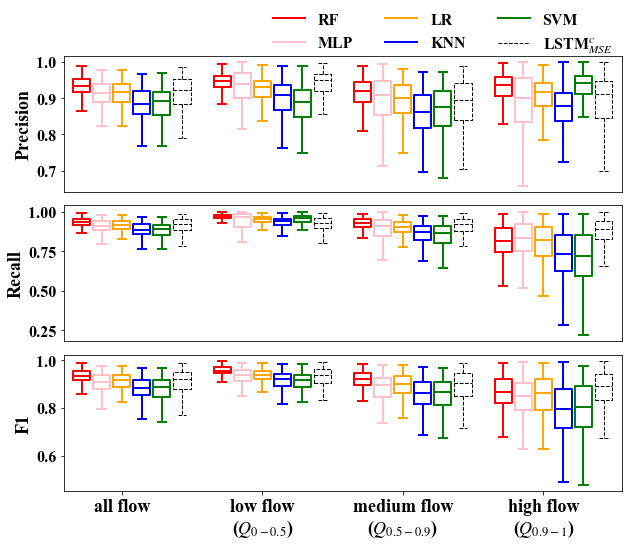

In [61]:
temp = ['precision_l', 'precision_m', 'precision_h', 'precision_micro', 'precision_macro', 'precision_weighted',
        'recall_l', 'recall_m', 'recall_h', 'recall_micro', 'recall_macro', 'recall_weighted', 
        'F1_l', 'F1_m', 'F1_h', 'F1_micro', 'F1_macro', 'F1_weighted']
choosen = [5,0,1,2,11,6,7,8,17,12,13,14]
CMs = ['RF', 'MLP','LR','KNN','SVM']
lines_attribute = ['whiskers','caps','medians','boxes']
color_set = ['r','pink','orange','b','g','k']
positions = np.array([1,8,15,22])

fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(10,8))

box_record = []
for CM in range(5):
    f = axs[0].boxplot(CM_indicators[:,CM,[5,0,1,2]],showfliers=False,widths=0.85,positions=positions+CM)
    box_record.append(f)
    for i in lines_attribute:
        for j in f[i]:
            j.set(color=color_set[CM], linewidth=2)
f = axs[0].boxplot(CM_LSTM_indicators[:,[5,0,1,2]],showfliers=False,widths=0.85,positions=positions+5)
box_record.append(f)
for i in lines_attribute:
    for j in f[i]:
        j.set(color=color_set[5], linewidth=1,ls='--')
axs[0].set_ylabel('Precision', fontsize = 18)
axs[0].set_xticks([])
axs[0].set_xlim(0.1,27.9)

for CM in range(5):
    f = axs[1].boxplot(CM_indicators[:,CM,[11,6,7,8]],showfliers=False,widths=0.85,positions=positions+CM)
    for i in lines_attribute:
        for j in f[i]:
            j.set(color=color_set[CM], linewidth=2)
f = axs[1].boxplot(CM_LSTM_indicators[:,[11,6,7,8]],showfliers=False,widths=0.85,positions=positions+5)
for i in lines_attribute:
    for j in f[i]:
        j.set(color=color_set[5], linewidth=1,ls='--')
axs[1].set_ylabel('Recall', fontsize = 18)
axs[1].set_xticks([])
axs[1].set_xlim(0.1,27.9)

for CM in range(5):
    f = axs[2].boxplot(CM_indicators[:,CM,[17,12,13,14]],showfliers=False,widths=0.85,positions=positions+CM)
    for i in lines_attribute:
        for j in f[i]:
            j.set(color=color_set[CM], linewidth=2)
f = axs[2].boxplot(CM_LSTM_indicators[:,[17,12,13,14]],showfliers=False,widths=0.85,positions=positions+5)
for i in lines_attribute:
    for j in f[i]:
        j.set(color=color_set[5], linewidth=1,ls='--')
axs[2].set_ylabel('F1', fontsize = 18)
axs[2].set_xticks([3,10,17,24])
axs[2].set_xticklabels(['all flow','low flow\n($Q_{0-0.5}$)','medium flow\n($Q_{0.5-0.9}$)','high flow\n($Q_{0.9-1}$)'], fontsize = 18)
axs[2].set_xlim(0.1,27.9)

# 设置图例
# axs[0].text(1, pd.Series(CM_indicators[:,0,2]).quantile(0.98),CMs[0],
#                 verticalalignment ='bottom',horizontalalignment ='center',fontsize=16)
# axs[0].text(2, pd.Series(CM_indicators[:,1,2]).quantile(0.185),CMs[1],
#                 verticalalignment ='top',horizontalalignment ='center',fontsize=16)
# axs[0].text(3, pd.Series(CM_indicators[:,2,2]).quantile(0.97),CMs[2],
#                 verticalalignment ='bottom',horizontalalignment ='center',fontsize=16)
# axs[0].text(4, pd.Series(CM_indicators[:,3,2]).quantile(0.07),CMs[3],
#                 verticalalignment ='top',horizontalalignment ='center',fontsize=16)
# axs[0].text(5, pd.Series(CM_indicators[:,4,2]).quantile(0.92),CMs[4],
#                 verticalalignment ='bottom',horizontalalignment ='center',fontsize=16)
# axs[0].text(6, pd.Series(CM_LSTM_indicators[:,2]).quantile(0.12),'             LSTM$_{MSE}^{c}$',
#                 verticalalignment ='top',horizontalalignment ='center',fontsize=16)
# axs[0].set_ylim(0.63,1.05)

axs[0].legend([i['boxes'][0] for i in box_record],['RF', 'MLP','LR','KNN','SVM','LSTM$_{MSE}^{c}$'],ncol=3,bbox_to_anchor=(0.35,0.9),frameon=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
plt.savefig(r'F:\objcetive_based_ensemble\figures\diff_CM_performance.jpg',dpi=300)
plt.show()

In [477]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_indicators_a = []
lstm_indicators_l = []
lstm_indicators_m = []
lstm_indicators_h = []
lstm_dl_indicators_a = []
lstm_dl_indicators_l = []
lstm_dl_indicators_m = []
lstm_dl_indicators_h = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_lstm = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_l = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_h = np.array(json.load(f))
        
    lstm_indicators_a.append(evaluation_indicators(ytest, ytest_lstm))
    lstm_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_lstm[ytest<low_flood]))
    lstm_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                   ytest_lstm[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood],  ytest_lstm[ytest>high_flood]))
    
    lstm_dl_indicators_a.append([])
    lstm_dl_indicators_l.append([])
    lstm_dl_indicators_m.append([])
    lstm_dl_indicators_h.append([])
    CMs = ['RF', 'MLP','LR','KNN','SVM']
    for CM in CMs:       
        with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\%s_SL_0.5_0.9\%s.json'%(CM,stationID), 'r') as f:
            ytestSL_ = np.array(json.load(f))

        ytest_ = ytest_lstm.copy()
        ytest_[ytestSL_==1] = ytest_l[ytestSL_==1]
        ytest_[ytestSL_==3] = ytest_h[ytestSL_==3]
       
        lstm_dl_indicators_a[-1].append(evaluation_indicators(ytest, ytest_))
        lstm_dl_indicators_l[-1].append(evaluation_indicators(ytest[ytest<low_flood], ytest_[ytest<low_flood]))
        lstm_dl_indicators_m[-1].append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                              ytest_[(ytest>=low_flood)&(ytest<=high_flood)]))
        lstm_dl_indicators_h[-1].append(evaluation_indicators(ytest[ytest>high_flood], ytest_[ytest>high_flood]))
    
lstm_indicators_a = np.array(lstm_indicators_a)
lstm_indicators_l = np.array(lstm_indicators_l)
lstm_indicators_m = np.array(lstm_indicators_m)
lstm_indicators_h = np.array(lstm_indicators_h)
lstm_dl_indicators_a = np.array(lstm_dl_indicators_a)
lstm_dl_indicators_l = np.array(lstm_dl_indicators_l)
lstm_dl_indicators_m = np.array(lstm_dl_indicators_m)
lstm_dl_indicators_h = np.array(lstm_dl_indicators_h)

273


In [504]:
print('保持结果到excel')

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']
CMs = ['RF', 'MLP','LR','KNN','SVM']

write = pd.ExcelWriter(r'F:\objcetive_based_ensemble\figures\metrics.xlsx')

results = pd.DataFrame(lstm_indicators_a, columns = temp).describe().round(4)
results = results.set_index(pd.Index(['lstm']*8), append=True)
for i in range(5):
    results = results.append(pd.DataFrame(lstm_dl_indicators_a[:,i,:], columns = temp).describe().round(4).set_index(pd.Index([CMs[i]]*8), append=True))
results.to_excel(write,sheet_name='all_flow')

results = pd.DataFrame(lstm_indicators_l, columns = temp).describe().round(4)
results = results.set_index(pd.Index(['lstm']*8), append=True)
for i in range(5):
    results = results.append(pd.DataFrame(lstm_dl_indicators_l[:,i,:], columns = temp).describe().round(4).set_index(pd.Index([CMs[i]]*8), append=True))
results.to_excel(write,sheet_name='low_flow')

results = pd.DataFrame(lstm_indicators_m, columns = temp).describe().round(4)
results = results.set_index(pd.Index(['lstm']*8), append=True)
for i in range(5):
    results = results.append(pd.DataFrame(lstm_dl_indicators_m[:,i,:], columns = temp).describe().round(4).set_index(pd.Index([CMs[i]]*8), append=True))
results.to_excel(write,sheet_name='medium_flow')

results = pd.DataFrame(lstm_indicators_h, columns = temp).describe().round(4)
results = results.set_index(pd.Index(['lstm']*8), append=True)
for i in range(5):
    results = results.append(pd.DataFrame(lstm_dl_indicators_h[:,i,:], columns = temp).describe().round(4).set_index(pd.Index([CMs[i]]*8), append=True))
results.to_excel(write,sheet_name='high_flow')

write.save()

保持结果到excel
